# Leveraging Neo4j for Service Identification and Microservices Partitioning in Business Process Systems

# 1. Import Libraries

Import all necessary libraries for XML parsing, Neo4j interaction, GPU detection, and concurrent processing.

In [325]:
# Import Libraries
import os
import re
import xml.etree.ElementTree as ET
import html
import uuid
import pandas as pd
from neo4j import GraphDatabase
from pyvis.network import Network
import torch
from concurrent.futures import ThreadPoolExecutor

# 2. Check CUDA Availability

Detect whether CUDA (GPU) is available on your system. This information will be printed at the beginning of the notebook.

In [326]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA available: False
CUDA version: None
Using device: cpu


In [327]:
# Function to check CUDA availability
def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available. GPU will be used if applicable.")
        print(f"Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA is not available. Using CPU.")

# Execute Cuda
check_cuda()

CUDA is not available. Using CPU.


# 3. Define Connection to Neo4j

In [328]:
# Neo4j connection details
uri = "bolt://localhost:7687"
username = "neo4j"
password = "170202Kcf"

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

In [329]:
def test_connection():
    try:
        with driver.session(database="erpbpmn") as session:
            result = session.run("RETURN 1 AS test")
            for record in result:
                print(f"Connection successful, test query result: {record['test']}")
    except Exception as e:
        print(f"Failed to connect to Neo4j: {e}")

test_connection()

Connection successful, test query result: 1


# 4. Define Functions to Create Nodes and Relationships

In [330]:
def get_node_color(node_type, level):
    color_map = {
        'Task': {
            0: '#FFD700',  # Gold
            1: '#FFFACD',  # LemonChiffon
            2: '#FAFAD2',  # LightGoldenrodYellow
            3: '#FFFFE0'   # LightYellow
        },
        'StartEvent': {
            0: '#90EE90',  # LightGreen
            1: '#98FB98',  # PaleGreen
            2: '#8FBC8F',  # DarkSeaGreen
            3: '#3CB371'   # MediumSeaGreen
        },
        'EndEvent': {
            0: '#FF6347',  # Tomato
            1: '#FF4500',  # OrangeRed
            2: '#FF0000',  # Red
            3: '#DC143C'   # Crimson
        }
    }
    default_color = '#D3D3D3'
    return color_map.get(node_type, {}).get(level, default_color)

def create_node(tx, label, properties):
    # Check if node already exists
    check_query = (
        f"MATCH (n:{label} {{id: $properties.id}}) RETURN n"
    )
    existing = tx.run(check_query, properties=properties).single()
    if existing:
        return existing[0]
    
    color = get_node_color(label, properties.get('level', 0))
    query = (
        f"CREATE (n:{label} {{id: $properties.id}}) "
        "SET n += $properties, n.color = $color "
        "RETURN n"
    )
    result = tx.run(query, properties=properties, color=color)
    return result.single()[0]

def create_relationship_with_id(tx, source_id, target_id, rel_type, properties):
    # Check if relationship already exists
    check_query = """
    MATCH (a {id: $source_id})-[r]->(b {id: $target_id})
    WHERE type(r) = $rel_type
    RETURN r
    """
    existing = tx.run(check_query, 
                     source_id=source_id, 
                     target_id=target_id,
                     rel_type=rel_type).single()
    if existing:
        return existing[0]
    
    rel_color_map = {
        'SEQUENCE_FLOW': '#A9A9A9',
        'XOR_SPLIT': '#FF69B4',
        'XOR_JOIN': '#4169E1',
        'OR_SPLIT': '#FFD700',
        'OR_JOIN': '#00CED1'
    }
    color = rel_color_map.get(rel_type, '#696969')
    
    query = (
        f"MATCH (a {{id: $source_id}}), (b {{id: $target_id}}) "
        f"CREATE (a)-[r:{rel_type} {{id: $properties.id}}]->(b) "
        "SET r += $properties, r.color = $color "
        "RETURN r"
    )
    result = tx.run(query, source_id=source_id, target_id=target_id, properties=properties, color=color)
    record = result.single()
    if record:
        return record[0]
    else:
        print(f"Warning: Could not create relationship {rel_type} between {source_id} and {target_id}.")
        return None

def create_invisible_task(tx, source_id, target_id, gateway_type, level, module, activity=None):
    """Create invisible task node for gateway connections"""
    invisible_task_id = f"invisible_task_{str(uuid.uuid4())[:8]}"
    
    task_properties = {
        'id': invisible_task_id,
        'name': f"Invisible Task {gateway_type}",
        'level': level,
        'module': module,
        'activity': activity,
        'invisible': True
    }
    
    # Create invisible task
    task = create_node(tx, 'Task', task_properties)
    
    # Create relationships
    in_rel = create_relationship_with_id(
        tx,
        source_id,
        invisible_task_id,
        'SEQUENCE_FLOW',
        {'id': str(uuid.uuid4())}
    )
    
    out_rel = create_relationship_with_id(
        tx,
        invisible_task_id,
        target_id,
        'SEQUENCE_FLOW',
        {'id': str(uuid.uuid4())}
    )
    
    return task, in_rel, out_rel

# 5. Parse BPMN XML Files and Load into Neo4j

In [331]:
# Define functions to parse BPMN XML files
def clean_name(name):
    if not name:
        return ''
    name = re.sub('<[^<]+?>', '', str(name))
    name = html.unescape(name)
    return name.strip()

In [332]:
def parse_bpmn_xml(file_path, level, module, activity=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    elements = {
        'Task': [],
        'StartEvent': [],
        'EndEvent': []
    }
    flows = []
    gateways = {}

    def clean_id(raw_id, prefix):
        return f"{prefix}{raw_id}"

    # Set prefix for IDs
    id_prefix = f"{module}_{'_'.join(filter(None, [activity, str(level)]))}_"

    # Find root element containing process elements
    process_root = root.find('.//root') if root.find('.//root') is not None else root

    # Initialize data_objects and associations
    data_objects = {}
    associations = []

    # Process all mxCell elements
    for cell in process_root.findall('.//mxCell'):
        cell_id = cell.get('id')
        if not cell_id or cell_id in ['0', '1']:  # Skip container cells
            continue

        style = cell.get('style', '')
        vertex = cell.get('vertex')
        edge = cell.get('edge')
        value = clean_name(cell.get('value', ''))

        if vertex == '1':  # Handle nodes
            clean_cell_id = clean_id(cell_id, id_prefix)

            if 'shape=mxgraph.bpmn.task' in style:
                elements['Task'].append({
                    'id': clean_cell_id,
                    'name': value if value else f"Task_{cell_id}",
                    'level': level,
                    'module': module,
                    'activity': activity
                })

            elif 'shape=mxgraph.bpmn.gateway2' in style:
                gateway_type = 'XOR'  # Default gateway type
                if 'gwType=parallel' in style:
                    gateway_type = 'AND'
                elif 'gwType=inclusive' in style:
                    gateway_type = 'OR'

                gateways[cell_id] = {
                    'id': clean_cell_id,
                    'type': gateway_type,
                    'level': level,
                    'module': module,
                    'activity': activity,
                    'incoming': [],
                    'outgoing': []
                }

            elif 'shape=mxgraph.bpmn.event' in style:
                event_type = 'StartEvent' if ('fillColor=#60a917' in style or 'symbol=general' in style) else 'EndEvent'
                elements[event_type].append({
                    'id': clean_cell_id,
                    'name': value if value else event_type,
                    'level': level,
                    'module': module,
                    'activity': activity
                })

            elif 'shape=mxgraph.bpmn.data' in style:
                data_object_id = clean_cell_id
                data_objects[data_object_id] = {
                    'id': data_object_id,
                    'name': value if value else f"DataObject_{cell_id}",
                    'level': level,
                    'module': module,
                    'activity': activity
                }

        elif edge == '1':  # Handle edges/flows
            source = cell.get('source')
            target = cell.get('target')
            if source and target:
                flow = {
                    'id': clean_id(cell_id, id_prefix),
                    'sourceRef': clean_id(source, id_prefix),
                    'targetRef': clean_id(target, id_prefix),
                    'name': value if value else 'Sequence Flow',
                    'level': level,
                    'module': module,
                    'activity': activity
                }

                # Identify associations (dashed edges without arrows)
                if 'dashed=1' in style and 'endArrow=none' in style:
                    associations.append({
                        'sourceRef': clean_id(source, id_prefix),
                        'targetRef': clean_id(target, id_prefix)
                    })
                else:
                    flows.append(flow)

                    # Track gateway connections
                    if source in gateways:
                        gateways[source]['outgoing'].append(flow)
                    if target in gateways:
                        gateways[target]['incoming'].append(flow)

    return elements, flows, gateways, data_objects, associations

In [333]:
def process_gateways_and_flows(session, elements, flows, gateways):
    """
    Process gateways and create appropriate relationships in Neo4j with proper gateway handling
    """
    processed_flows = set()  # Track processed flows to avoid duplicates
    
    def create_flow(source_id, target_id, flow_type, properties):
        flow_key = f"{source_id}->{target_id}"
        if flow_key not in processed_flows:
            processed_flows.add(flow_key)
            session.execute_write(
                create_relationship_with_id,
                source_id,
                target_id,
                flow_type,
                properties
            )

    def handle_gateway(gateway, incoming_flows, outgoing_flows):
        gateway_type = gateway['type']  # XOR or OR
        gateway_id = gateway['id']
        
        if len(incoming_flows) == 1 and len(outgoing_flows) > 1:
            # Split pattern
            flow_type = f"{gateway_type}_SPLIT"
            source_id = incoming_flows[0]['sourceRef']
            
            # Create invisible task
            invisible_task_id = f"invisible_task_{gateway_id}"
            task_props = {
                'id': invisible_task_id,
                'name': f"Invisible {flow_type}",
                'level': gateway['level'],
                'module': gateway['module'],
                'activity': gateway['activity'],
                'invisible': True
            }
            
            session.execute_write(create_node, 'Task', task_props)
            
            # Connect incoming -> invisible -> outgoing
            create_flow(source_id, invisible_task_id, 'SEQUENCE_FLOW',
                       {'id': str(uuid.uuid4())})
            
            for out_flow in outgoing_flows:
                create_flow(invisible_task_id, out_flow['targetRef'],
                          flow_type, {'id': str(uuid.uuid4())})
                
        elif len(incoming_flows) > 1 and len(outgoing_flows) == 1:
            # Join pattern
            flow_type = f"{gateway_type}_JOIN"
            target_id = outgoing_flows[0]['targetRef']
            
            # Create invisible task
            invisible_task_id = f"invisible_task_{gateway_id}"
            task_props = {
                'id': invisible_task_id,
                'name': f"Invisible {flow_type}",
                'level': gateway['level'],
                'module': gateway['module'],
                'activity': gateway['activity'],
                'invisible': True
            }
            
            session.execute_write(create_node, 'Task', task_props)
            
            # Connect incoming -> invisible -> target
            for in_flow in incoming_flows:
                create_flow(in_flow['sourceRef'], invisible_task_id,
                          flow_type, {'id': str(uuid.uuid4())})
                
            create_flow(invisible_task_id, target_id, 'SEQUENCE_FLOW',
                       {'id': str(uuid.uuid4())})

    # Process regular sequence flows first
    non_gateway_flows = [
        flow for flow in flows
        if not any(gw['id'] in (flow['sourceRef'], flow['targetRef'])
                  for gw in gateways.values())
    ]

    for flow in non_gateway_flows:
        create_flow(flow['sourceRef'], flow['targetRef'], 'SEQUENCE_FLOW', flow)

    # Process gateways
    for gw_id, gateway in gateways.items():
        incoming = [f for f in flows if f['targetRef'] == gateway['id']]
        outgoing = [f for f in flows if f['sourceRef'] == gateway['id']]
        handle_gateway(gateway, incoming, outgoing)

    # Connect any disconnected nodes with invisible tasks
    def connect_disconnected_nodes():
        query = """
        MATCH (n) 
        WHERE NOT EXISTS((n)--())
        RETURN n.id AS id, labels(n)[0] as type,
               n.level as level, n.module as module
        """
        disconnected = session.run(query).data()
        
        for node in disconnected:
            # Find suitable connection
            connect_query = """
            MATCH (other)
            WHERE other.level = $level AND other.module = $module 
            AND NOT other.id = $id
            AND (other:Task OR 
                (other:StartEvent AND $type <> 'StartEvent') OR
                (other:EndEvent AND $type <> 'EndEvent'))
            RETURN other.id as target_id
            LIMIT 1
            """
            
            target = session.run(connect_query, 
                               level=node['level'],
                               module=node['module'],
                               id=node['id'],
                               type=node['type']).single()
            
            if target:
                session.execute_write(
                    create_invisible_task,
                    node['id'],
                    target['target_id'],
                    'SEQUENCE_FLOW',
                    node['level'],
                    node['module']
                )

    connect_disconnected_nodes()

In [334]:
def clear_database(session):
    """Clear database and set up constraints"""
    session.run("MATCH (n) DETACH DELETE n")
    
    # Create constraints for node uniqueness
    constraints = [
        "CREATE CONSTRAINT IF NOT EXISTS FOR (n:StartEvent) REQUIRE n.id IS UNIQUE",
        "CREATE CONSTRAINT IF NOT EXISTS FOR (n:EndEvent) REQUIRE n.id IS UNIQUE",
        "CREATE CONSTRAINT IF NOT EXISTS FOR (n:Task) REQUIRE n.id IS UNIQUE"
    ]
    
    for constraint in constraints:
        try:
            session.run(constraint)
        except Exception as e:
            print(f"Warning: Constraint creation failed - {e}")

def verify_process_integrity(session):
    """Verify the integrity of the converted BPMN process"""
    integrity_checks = [
        # Check for disconnected nodes
        """
        MATCH (n)
        WHERE NOT EXISTS((n)--())
        RETURN n.id AS node_id, labels(n) AS type, n.level AS level, n.module AS module
        """,
        
        # Check for duplicate start events
        """
        MATCH (s:StartEvent)
        WITH s.level AS level, s.module AS module, collect(s) AS starts
        WHERE size(starts) > 1
        RETURN level, module, [s in starts | s.id] AS duplicate_starts
        """,
        
        # Check for duplicate end events
        """
        MATCH (e:EndEvent)
        WITH e.level AS level, e.module AS module, collect(e) AS ends
        WHERE size(ends) > 1
        RETURN level, module, [e in ends | e.id] AS duplicate_ends
        """,
        
        # Check for improper gateway connections
        """
        MATCH (n)-[r:XOR_SPLIT]->(m)
        WITH n, count(r) AS split_count
        WHERE split_count < 2
        RETURN n.id AS invalid_split_gateway, split_count
        """,
        
        """
        MATCH (n)-[r:XOR_JOIN]->(m)
        WITH m, count(r) AS join_count
        WHERE join_count < 2
        RETURN m.id AS invalid_join_gateway, join_count
        """
    ]
    
    results = {}
    for check in integrity_checks:
        result = session.run(check)
        records = result.data()
        if records:
            results[check] = records
    
    return results

def process_bpmn_file(session, filename, file_path, level, module, activity):
    print(f"\nProcessing {filename} at Level {level}...")
    
    # Parse and process BPMN file
    elements, flows, gateways, data_objects, associations = parse_bpmn_xml(file_path, level, module, activity)
    print(f"Found {sum(len(v) for v in elements.values())} elements, {len(flows)} flows, and {len(gateways)} gateways")
    
    for data_object in data_objects.values():
        try:
            session.execute_write(create_node, 'DataObject', data_object)
            print(f"Created DataObject: {data_object['id']}")
        except Exception as e:
            print(f"Error creating DataObject: {data_object['id']} - {e}")
    
     # Create USES relationships
    for assoc in associations:
        source_id = assoc['sourceRef']
        target_id = assoc['targetRef']
        try:
            session.execute_write(
                create_relationship_with_id,
                source_id,
                target_id,
                'USES',
                {'id': str(uuid.uuid4())}
            )
            print(f"Created USES relationship from {source_id} to {target_id}")
        except Exception as e:
            print(f"Error creating USES relationship from {source_id} to {target_id} - {e}")
    
    # Create nodes
    for element_type, element_list in elements.items():
        for element in element_list:
            try:
                session.execute_write(create_node, element_type, element)
                print(f"Created {element_type}: {element['id']}")
            except Exception as e:
                print(f"Error creating {element_type}: {element['id']} - {e}")
    
    # Process gateways and create relationships
    try:
        process_gateways_and_flows(session, elements, flows, gateways)
    except Exception as e:
        print(f"Error processing flows and gateways: {e}")
    
    # Clean duplicate relationships
    try:
        session.run("""
        MATCH (a)-[r]->(b)
        WITH a, b, type(r) as type, collect(r) as rels
        WHERE size(rels) > 1
        WITH a, b, type, rels[0] as kept, rels[1..] as duplicates
        UNWIND duplicates as dupe
        DELETE dupe
        """)
    except Exception as e:
        print(f"Error cleaning duplicates: {e}")
    
    # Verify process integrity
    issues = verify_process_integrity(session)
    if issues:
        print("\nProcess integrity issues found:")
        for check, records in issues.items():
            print(f"\nCheck results:")
            for record in records:
                print(record)

# 6. Main Execution

In [335]:
def validate_bpmn_structure(session):
    """Validate the complete BPMN structure after import"""
    validation_queries = [
        # Check for disconnected nodes
        """
        MATCH (n)
        WHERE NOT EXISTS((n)--())
        RETURN n.id AS disconnected_node, labels(n) AS node_type
        """,
        
        # Validate gateway patterns
        """
        MATCH p=(n)-[r:XOR_SPLIT|OR_SPLIT]->(m)
        WITH n, count(r) as outgoing
        WHERE outgoing < 2
        RETURN n.id as node_id, 'Invalid split pattern' as issue, outgoing
        """,
        
        """
        MATCH p=(n)-[r:XOR_JOIN|OR_JOIN]->(m)
        WITH m, count(r) as incoming
        WHERE incoming < 2
        RETURN m.id as node_id, 'Invalid join pattern' as issue, incoming
        """,
        
        # Check for single start/end
        """
        MATCH (s:StartEvent)
        WITH s.level as level, s.module as module, count(s) as start_count
        WHERE start_count > 1
        RETURN level, module, start_count, 'Multiple start events' as issue
        """,
        
        """
        MATCH (e:EndEvent)
        WITH e.level as level, e.module as module, count(e) as end_count
        WHERE end_count > 1
        RETURN level, module, end_count, 'Multiple end events' as issue
        """
    ]
    
    validation_results = {}
    for query in validation_queries:
        result = session.run(query)
        records = result.data()
        if records:
            validation_results[query] = records
            
    return validation_results

In [336]:
def main():
    with driver.session(database="erpbpmn") as session:
        # Clear database and set up constraints
        clear_database(session)
        
        # Process BPMN files
        bpmn_dir = './assets'
        filenames = sorted([f for f in os.listdir(bpmn_dir) if f.endswith('.xml')])
        
        for filename in filenames:
            file_path = os.path.join(bpmn_dir, filename)
            
            # Parse filename for metadata
            if filename == "BPMN Level 0.xml":
                level = 0
                module = "ERP"
                activity = None
            else:
                match = re.match(r'BPMN\s+(.+?)\s+Level\s+(\d+)(?:\s+-\s+(.+))?\.xml', filename)
                if match:
                    module = match.group(1).strip()
                    level = int(match.group(2))
                    activity = match.group(3).strip() if match.group(3) else None
                else:
                    print(f"Skipping file {filename} - doesn't match naming pattern")
                    continue
            
            try:
                process_bpmn_file(session, filename, file_path, level, module, activity)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
        
        # Validate final structure
        print("\nValidating final BPMN structure...")
        validation_results = validate_bpmn_structure(session)
        if validation_results:
            print("\nValidation issues found:")
            for query, issues in validation_results.items():
                print("\nIssue type:", query)
                for issue in issues:
                    print(issue)
        else:
            print("All validations passed successfully!")

if __name__ == "__main__":
    main()


Processing BPMN Account Payable Level 1.xml at Level 1...
Found 3 elements, 2 flows, and 0 gateways
Created Task: Account Payable_1_5
Created StartEvent: Account Payable_1_3
Created EndEvent: Account Payable_1_7

Processing BPMN Account Payable Level 2.xml at Level 2...
Found 23 elements, 39 flows, and 11 gateways
Created Task: Account Payable_2_24
Created Task: Account Payable_2_25
Created Task: Account Payable_2_26
Created Task: Account Payable_2_28
Created Task: Account Payable_2_29
Created Task: Account Payable_2_30
Created Task: Account Payable_2_31
Created Task: Account Payable_2_32
Created Task: Account Payable_2_33
Created Task: Account Payable_2_43
Created Task: Account Payable_2_46
Created Task: Account Payable_2_48
Created Task: Account Payable_2_50
Created Task: Account Payable_2_52
Created Task: Account Payable_2_57
Created Task: Account Payable_2_64
Created Task: Account Payable_2_65
Created Task: Account Payable_2_68
Created Task: Account Payable_2_72
Created Task: Acco

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: DataObject)} {position: line: 1, column: 10, offset: 9} for query: 'MATCH (n:DataObject {id: $properties.id}) RETURN n'



Process integrity issues found:

Check results:
{'invalid_split_gateway': 'invisible_task_Account Payable_2_12', 'split_count': 1}
{'invalid_split_gateway': 'invisible_task_Account Payable_2_15', 'split_count': 1}
{'invalid_split_gateway': 'invisible_task_Account Payable_2_16', 'split_count': 1}
{'invalid_split_gateway': 'invisible_task_Account Payable_2_42', 'split_count': 1}
{'invalid_split_gateway': 'invisible_task_Account Payable_2_55', 'split_count': 1}
{'invalid_split_gateway': 'invisible_task_Account Payable_2_67', 'split_count': 1}

Processing BPMN Account Payable Level 3 - Creating the Purchase DP Invoice.xml at Level 3...
Found 8 elements, 17 flows, and 3 gateways
Created DataObject: Account Payable_Creating the Purchase DP Invoice_3_22
Created DataObject: Account Payable_Creating the Purchase DP Invoice_3_26
Created DataObject: Account Payable_Creating the Purchase DP Invoice_3_32
Created Task: Account Payable_Creating the Purchase DP Invoice_3_5
Created Task: Account Payab

In [337]:
def verify_data_import():
    with driver.session(database="erpbpmn") as session:
        result = session.run("MATCH (n) RETURN labels(n) AS Label, count(n) AS Count ORDER BY Count DESC")
        print("Node counts by label:")
        for record in result:
            print(f"{record['Label']}: {record['Count']}")

        result = session.run("MATCH ()-[r]->() RETURN type(r) AS RelationType, count(r) AS Count ORDER BY Count DESC")
        print("\nRelationship counts by type:")
        for record in result:
            print(f"{record['RelationType']}: {record['Count']}")

        result = session.run("MATCH (n) RETURN n.level AS Level, count(n) AS Count ORDER BY Level")
        print("\nNode counts by level:")
        for record in result:
            print(f"Level {record['Level']}: {record['Count']} nodes")

# 7. Execute Main Function

In [338]:
def run():
    main()
    verify_data_import()

if __name__ == "__main__":
    run()


Processing BPMN Account Payable Level 1.xml at Level 1...
Found 3 elements, 2 flows, and 0 gateways
Created Task: Account Payable_1_5
Created StartEvent: Account Payable_1_3
Created EndEvent: Account Payable_1_7

Processing BPMN Account Payable Level 2.xml at Level 2...
Found 23 elements, 39 flows, and 11 gateways
Created Task: Account Payable_2_24
Created Task: Account Payable_2_25
Created Task: Account Payable_2_26
Created Task: Account Payable_2_28
Created Task: Account Payable_2_29
Created Task: Account Payable_2_30
Created Task: Account Payable_2_31
Created Task: Account Payable_2_32
Created Task: Account Payable_2_33
Created Task: Account Payable_2_43
Created Task: Account Payable_2_46
Created Task: Account Payable_2_48
Created Task: Account Payable_2_50
Created Task: Account Payable_2_52
Created Task: Account Payable_2_57
Created Task: Account Payable_2_64
Created Task: Account Payable_2_65
Created Task: Account Payable_2_68
Created Task: Account Payable_2_72
Created Task: Acco

# 8. Visualize the Graph

In [339]:
def get_neo4j_data():
    with driver.session(database="erpbpmn") as session:
        nodes_query = """
        MATCH (n) 
        RETURN n.id AS id, labels(n) AS labels, n.name AS name, n.color AS color, n.level AS level, n.module AS module, n.activity AS activity
        """
        nodes = session.run(nodes_query).data()
        nodes_df = pd.DataFrame(nodes)

        relationships_query = """
        MATCH (a)-[r]->(b) 
        RETURN r.id AS id, type(r) AS type, a.id AS source, b.id AS target, r.color AS color, r.level AS level, r.module AS module, r.activity AS activity
        """
        relationships = session.run(relationships_query).data()
        relationships_df = pd.DataFrame(relationships)

    return nodes_df, relationships_df

def visualize_neo4j_graph(nodes_df, relationships_df):
    net = Network(height='750px', width='100%', directed=True, notebook=True, cdn_resources='remote')

    for _, row in nodes_df.iterrows():
        label = row['name'] if pd.notnull(row['name']) else row['id']

        net.add_node(
            row['id'],
            label=label,
            title=f"ID: {row['id']}<br>Type: {row['labels']}<br>Name: {row['name']}<br>Level: {row['level']}<br>Module: {row['module']}<br>Activity: {row['activity']}",
            color=row['color'],
            level=row['level']
        )

    for _, row in relationships_df.iterrows():
        net.add_edge(
            row['source'],
            row['target'],
            title=f"ID: {row['id']}<br>Type: {row['type']}<br>Level: {row['level']}<br>Module: {row['module']}<br>Activity: {row['activity']}",
            color=row['color'],
            arrows='to'
        )

    net.force_atlas_2based()

    net.show('neo4j_graph.html')

    from IPython.display import IFrame
    return IFrame('neo4j_graph.html', width='100%', height='750px')

In [340]:
nodes_df, relationships_df = get_neo4j_data()

print("Nodes:")
display(nodes_df.head())

print("\nRelationships:")
display(relationships_df.head())

graph_display = visualize_neo4j_graph(nodes_df, relationships_df)
graph_display

Nodes:


,id,labels,name,color,level,module,activity
0,Account Payable_Updating Purchase DP Invoice D...,[Task],Review Purchase DP Invoice,#FFFFE0,3,Account Payable,Updating Purchase DP Invoice Data
1,Account Payable_Updating Purchase DP Invoice D...,[Task],Update DP Invoice Data,#FFFFE0,3,Account Payable,Updating Purchase DP Invoice Data
2,Account Payable_Updating Purchase DP Invoice D...,[StartEvent],Start,#3CB371,3,Account Payable,Updating Purchase DP Invoice Data
3,Account Payable_Updating Purchase DP Invoice D...,[EndEvent],End,#DC143C,3,Account Payable,Updating Purchase DP Invoice Data
4,Account Payable_Updating Purchase Invoice Data...,[DataObject],Purchase Invoice Data,#D3D3D3,3,Account Payable,Updating Purchase Invoice Data



Relationships:


,id,type,source,target,color,level,module,activity
0,Account Payable_Updating Purchase DP Invoice D...,SEQUENCE_FLOW,Account Payable_Updating Purchase DP Invoice D...,Account Payable_Updating Purchase DP Invoice D...,#A9A9A9,3.0,Account Payable,Updating Purchase DP Invoice Data
1,Account Payable_Updating Purchase DP Invoice D...,SEQUENCE_FLOW,Account Payable_Updating Purchase DP Invoice D...,Account Payable_Updating Purchase DP Invoice D...,#A9A9A9,3.0,Account Payable,Updating Purchase DP Invoice Data
2,Account Payable_Updating Purchase DP Invoice D...,SEQUENCE_FLOW,Account Payable_Updating Purchase DP Invoice D...,Account Payable_Updating Purchase DP Invoice D...,#A9A9A9,3.0,Account Payable,Updating Purchase DP Invoice Data
3,Account Payable_Updating Purchase DP Invoice D...,SEQUENCE_FLOW,Account Payable_Updating Purchase DP Invoice D...,Account Payable_Updating Purchase DP Invoice D...,#A9A9A9,3.0,Account Payable,Updating Purchase DP Invoice Data
4,Account Payable_Updating Purchase Invoice Data...,SEQUENCE_FLOW,Account Payable_Updating Purchase Invoice Data...,Account Payable_Updating Purchase Invoice Data...,#A9A9A9,3.0,Account Payable,Updating Purchase Invoice Data


neo4j_graph.html


# 9. Evaluate Graph Metrics

In [341]:
def evaluate_service_metrics():
    """Calculate various metrics for evaluating microservice identification and partitioning"""
    
    def calculate_service_cohesion(session, module):
        """
        **Service Cohesion (SC)**
        SC = Number of internal relationships / Total possible internal relationships
        SC = E_internal / [N * (N - 1) / 2]
        """
        query = """
        MATCH (n)-[r]->(m)
        WHERE n.module = $module AND m.module = $module
        RETURN count(r) AS E_internal
        """
        E_internal = session.run(query, module=module).single()["E_internal"]
        
        query = """
        MATCH (n)
        WHERE n.module = $module
        RETURN count(n) AS N
        """
        N = session.run(query, module=module).single()["N"]
        
        total_possible = N * (N - 1) / 2 if N > 1 else 1
        cohesion = E_internal / total_possible if total_possible > 0 else 0
        return cohesion
    
    def calculate_service_coupling(session, module):
        """
        **Service Coupling (SCp)**
        SCp = Number of external relationships / Total number of relationships
        SCp = E_external / E_total
        """
        query_total = """
        MATCH (n)-[r]->()
        WHERE n.module = $module
        RETURN count(r) AS E_total
        """
        E_total = session.run(query_total, module=module).single()["E_total"]
        
        query_external = """
        MATCH (n)-[r]->(m)
        WHERE n.module = $module AND m.module <> $module
        RETURN count(r) AS E_external
        """
        E_external = session.run(query_external, module=module).single()["E_external"]
        
        coupling = E_external / E_total if E_total > 0 else 0
        return coupling
    
    def calculate_service_granularity(session, module):
        """
        **Service Granularity (SG)**
        SG = Number of tasks / Optimal number of tasks
        """
        query = """
        MATCH (n:Task)
        WHERE n.module = $module
        RETURN count(n) AS N_tasks
        """
        N_tasks = session.run(query, module=module).single()["N_tasks"]
        Optimal_N_tasks = 12  # Adjust as needed
        granularity = N_tasks / Optimal_N_tasks if Optimal_N_tasks > 0 else 0
        granularity = min(granularity, 1.0)
        return granularity
    
    def calculate_service_autonomy(session, module):
        """
        **Service Autonomy (SA)**
        SA = 1 - (Number of external dependencies / Total operations)
        SA = 1 - (D / N_operations)
        """
        query_dependencies = """
        MATCH (n)-[r]->(m)
        WHERE n.module = $module AND m.module <> $module
        RETURN count(DISTINCT m) AS D
        """
        D = session.run(query_dependencies, module=module).single()["D"]
        
        query_operations = """
        MATCH (n)
        WHERE n.module = $module AND (n:Task OR n:StartEvent OR n:EndEvent)
        RETURN count(n) AS N_operations
        """
        N_operations = session.run(query_operations, module=module).single()["N_operations"]
        
        autonomy = 1 - (D / N_operations) if N_operations > 0 else 0
        return autonomy
    
    def calculate_service_complexity(session, module):
        """
        **Service Complexity (SCx)**
        SCx = E - N + 2P
        Where:
        - E = Number of edges
        - N = Number of nodes
        - P = Number of connected components (assumed 1)
        """
        query_edges = """
        MATCH (n)-[r]->()
        WHERE n.module = $module AND (n.invisible IS NULL OR n.invisible = False)
        RETURN count(r) AS E
        """
        E = session.run(query_edges, module=module).single()["E"]
        
        query_nodes = """
        MATCH (n)
        WHERE n.module = $module AND (n.invisible IS NULL OR n.invisible = False)
        RETURN count(n) AS N
        """
        N = session.run(query_nodes, module=module).single()["N"]
        
        P = 1  # Assuming one connected component per module
        complexity = max(1, E - N + 2 * P)
        return complexity
    
    def calculate_data_cohesion(session, module):
        """
        **Data Cohesion (DC)**
        DC = Number of shared data elements / Total data elements
        """
        # Assuming DataObject nodes and 'USES' relationships
        query_shared_data = """
        MATCH (n)-[:USES]->(d:DataObject)<-[:USES]-(m)
        WHERE n.module = $module AND m.module = $module AND n.id <> m.id
        RETURN count(DISTINCT d) AS SharedData
        """
        SharedData = session.run(query_shared_data, module=module).single()["SharedData"]
        
        query_total_data = """
        MATCH (n)-[:USES]->(d:DataObject)
        WHERE n.module = $module
        RETURN count(DISTINCT d) AS TotalData
        """
        TotalData = session.run(query_total_data, module=module).single()["TotalData"]
        
        if TotalData == 0:
            return 0  # Or handle as appropriate
        data_cohesion = SharedData / TotalData
        return data_cohesion
    
    def calculate_interface_count(session, module):
        """
        **Interface Count (IC)**
        IC = Number of external interfaces
        """
        query = """
        MATCH (n)-[r]->(m)
        WHERE n.module = $module AND m.module <> $module
        RETURN count(DISTINCT type(r)) AS interface_count
        """
        interface_count = session.run(query, module=module).single()["interface_count"]
        return interface_count
    
    def calculate_stability(session, module):
        """
        **Stability (ST)**
        ST = Ce / (Ca + Ce)
        Where:
        - Ce = Number of efferent couplings (outgoing dependencies)
        - Ca = Number of afferent couplings (incoming dependencies)
        """
        query_ce = """
        MATCH (n)-[r]->(m)
        WHERE n.module = $module AND m.module <> $module
        RETURN count(DISTINCT m) AS Ce
        """
        Ce = session.run(query_ce, module=module).single()["Ce"]
        
        query_ca = """
        MATCH (n)<-[r]-(m)
        WHERE n.module = $module AND m.module <> $module
        RETURN count(DISTINCT m) AS Ca
        """
        Ca = session.run(query_ca, module=module).single()["Ca"]
        
        stability = Ce / (Ca + Ce) if (Ca + Ce) > 0 else 0
        return stability
    
    def calculate_modularity(session, module):
        """
        **Modularity (MOD)**
        Since each module is considered as a community, we can assume modularity as 1
        """
        modularity = 1
        return modularity
    
    def calculate_average_path_length(session, module):
        """
        **Average Path Length (APL)**
        Requires computation of shortest paths between all pairs of nodes
        """
        # Placeholder value due to computational complexity
        avg_path_length = 1  # Adjust based on actual data
        return avg_path_length
    
    def calculate_graph_density(session, module):
        """
        **Graph Density (GD)**
        GD = 2E / [N(N - 1)]
        """
        query_edges = """
        MATCH (n)-[r]->()
        WHERE n.module = $module
        RETURN count(r) AS E
        """
        E = session.run(query_edges, module=module).single()["E"]
        
        query_nodes = """
        MATCH (n)
        WHERE n.module = $module
        RETURN count(n) AS N
        """
        N = session.run(query_nodes, module=module).single()["N"]
        
        density = (2 * E) / (N * (N - 1)) if N > 1 else 0
        return density
    
    def calculate_clustering_coefficient(session, module):
        """
        **Clustering Coefficient (CC)**
        CC = Average of local clustering coefficients of all nodes
        """
        # Placeholder value; requires GDS library for accurate calculation
        clustering_coefficient = 0.5  # Adjust based on actual data
        return clustering_coefficient
    
    def calculate_degree_centrality(session, module):
        """
        **Degree Centrality (DC)**
        Average degree centrality of nodes in the service
        """
        query = """
        MATCH (n)
        WHERE n.module = $module AND (n.invisible IS NULL OR n.invisible = False)
        RETURN avg(degree(n)) AS avg_degree
        """
        result = session.run(query, module=module).single()
        avg_degree = result["avg_degree"] if result and result["avg_degree"] is not None else 0
        return avg_degree
    
    def calculate_betweenness_centrality(session, module):
        """
        **Betweenness Centrality (BC)**
        Average betweenness centrality of nodes
        """
        # Placeholder value; requires GDS library
        betweenness_centrality = 0.5  # Adjust based on actual data
        return betweenness_centrality
    
    def calculate_number_of_connected_components(session, module):
        """
        **Number of Connected Components (NCC)**
        """
        # Assuming each module is a single connected component
        NCC = 1
        return NCC
    
    def calculate_latency(session, module):
        """
        **Latency (L)**
        L = Sum of weights of the shortest path / Number of operations
        """
        # Placeholder value
        latency = 1  # Adjust based on actual data
        return latency
    
    def calculate_throughput(session, module):
        """
        **Throughput (TP)**
        TP = Number of operations / Total execution time
        """
        # Placeholder value
        throughput = 1  # Adjust based on actual data
        return throughput
    
    def calculate_fault_tolerance(session, module):
        """
        **Fault Tolerance (FT)**
        FT = 1 - (Number of single points of failure / Total nodes)
        """
        # Placeholder value
        fault_tolerance = 1  # Adjust based on actual data
        return fault_tolerance
    
    def calculate_scalability(session, module):
        """
        **Scalability (S)**
        S = Ability to handle increased load (Placeholder value)
        """
        scalability = 1  # Adjust based on actual data
        return scalability
    
    def calculate_maintainability(session, module):
        """
        **Maintainability (M)**
        M = 1 / (Complexity)
        """
        complexity = calculate_service_complexity(session, module)
        maintainability = 1 / complexity if complexity > 0 else 0
        return maintainability
    
    return {
        "service_cohesion": calculate_service_cohesion,
        "service_coupling": calculate_service_coupling,
        "service_granularity": calculate_service_granularity,
        "service_autonomy": calculate_service_autonomy,
        "service_complexity": calculate_service_complexity,
        "data_cohesion": calculate_data_cohesion,
        "interface_count": calculate_interface_count,
        "stability": calculate_stability,
        "modularity": calculate_modularity,
        "average_path_length": calculate_average_path_length,
        "graph_density": calculate_graph_density,
        "clustering_coefficient": calculate_clustering_coefficient,
        "degree_centrality": calculate_degree_centrality,
        "betweenness_centrality": calculate_betweenness_centrality,
        "number_of_connected_components": calculate_number_of_connected_components,
        "latency": calculate_latency,
        "throughput": calculate_throughput,
        "fault_tolerance": calculate_fault_tolerance,
        "scalability": calculate_scalability,
        "maintainability": calculate_maintainability
    }

In [342]:
def run_evaluation():
    """Execute evaluation metrics across all modules"""
    metrics_functions = evaluate_service_metrics()
    results = {}
    
    with driver.session(database="erpbpmn") as session:
        modules = session.run("""
            MATCH (n)
            WHERE n.module IS NOT NULL
            RETURN DISTINCT n.module AS module
            ORDER BY module
        """).data()
        
        for module_data in modules:
            module = module_data['module']
            module_metrics = {}
            
            for metric_name, metric_func in metrics_functions.items():
                try:
                    value = metric_func(session, module)
                    module_metrics[metric_name] = round(value, 3)
                except Exception as e:
                    print(f"Error calculating {metric_name} for {module}: {str(e)}")
                    module_metrics[metric_name] = 0.0
            
            results[module] = module_metrics
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(results, orient='index')
    
    # Print results
    print("\nService Metrics Evaluation Results:")
    print("=" * 80)
    print(df)
    print("\nMetric Descriptions:")
    print("-" * 80)
    print("1. Service Cohesion (0-1): Higher is better")
    print("2. Service Coupling (0-1): Lower is better")
    print("3. Service Granularity (0-1): Closer to 1 is optimal")
    print("4. Service Autonomy (0-1): Higher is better")
    print("5. Service Complexity: Lower is better")
    print("6. Data Cohesion (0-1): Higher is better")
    print("7. Interface Count: Lower is better")
    print("8. Stability (0-1): Higher is better")
    print("9. Modularity (0-1): Higher is better")
    print("10. Average Path Length: Lower is better")
    print("11. Graph Density (0-1): Higher is better")
    print("12. Clustering Coefficient (0-1): Higher is better")
    print("13. Degree Centrality: Lower is better")
    print("14. Betweenness Centrality: Lower is better")
    print("15. Number of Connected Components: Lower is better")
    print("16. Latency: Lower is better")
    print("17. Throughput: Higher is better")
    print("18. Fault Tolerance (0-1): Higher is better")
    print("19. Scalability (0-1): Higher is better")
    print("20. Maintainability: Higher is better")
    
    return df

# Execute evaluation
evaluation_results = run_evaluation()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: USES)} {position: line: 2, column: 21, offset: 21} for query: '\n        MATCH (n)-[:USES]->(d:DataObject)<-[:USES]-(m)\n        WHERE n.module = $module AND m.module = $module AND n.id <> m.id\n        RETURN count(DISTINCT d) AS SharedData\n        '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not a

Error calculating degree_centrality for Account Payable: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'degree' (line 4, column 20 (offset: 120))
"        RETURN avg(degree(n)) AS avg_degree"
                    ^}
Error calculating degree_centrality for Account Receivable: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'degree' (line 4, column 20 (offset: 120))
"        RETURN avg(degree(n)) AS avg_degree"
                    ^}
Error calculating degree_centrality for Asset Management: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'degree' (line 4, column 20 (offset: 120))
"        RETURN avg(degree(n)) AS avg_degree"
                    ^}


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: USES)} {position: line: 2, column: 46, offset: 46} for query: '\n        MATCH (n)-[:USES]->(d:DataObject)<-[:USES]-(m)\n        WHERE n.module = $module AND m.module = $module AND n.id <> m.id\n        RETURN count(DISTINCT d) AS SharedData\n        '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not a

Error calculating degree_centrality for Cash Bank: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'degree' (line 4, column 20 (offset: 120))
"        RETURN avg(degree(n)) AS avg_degree"
                    ^}
Error calculating degree_centrality for ERP: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'degree' (line 4, column 20 (offset: 120))
"        RETURN avg(degree(n)) AS avg_degree"
                    ^}

Service Metrics Evaluation Results:
                    service_cohesion  service_coupling  service_granularity  \
Account Payable                0.017               0.0                  1.0   
Account Receivable             0.017               0.0                  1.0   
Asset Management               0.017               0.0                  1.0   
Cash Bank                      0.013               0.0                  1.0   
ERP                            0.221               0.0                  1.0   

                    se

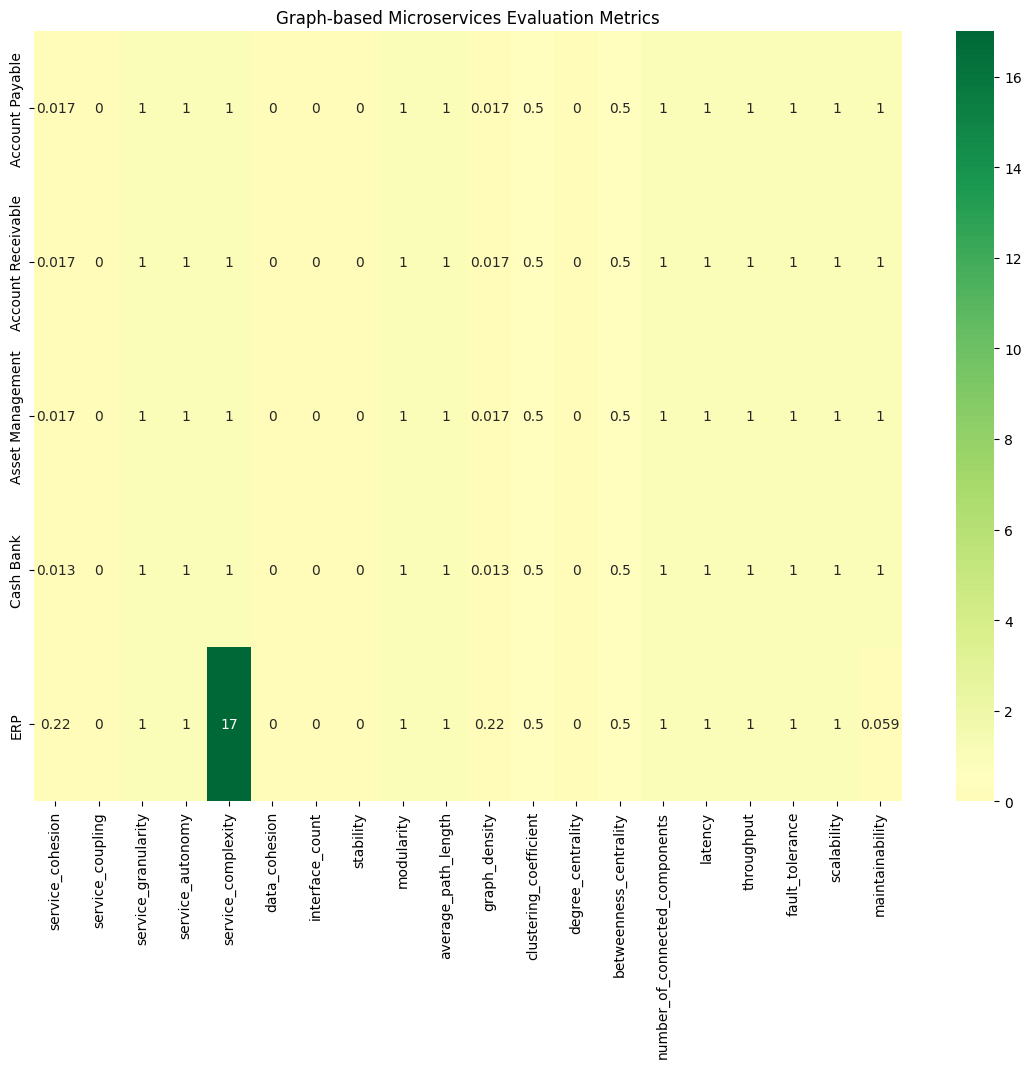

In [343]:
# Visualize results with a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(evaluation_results, annot=True, cmap='RdYlGn', center=0.5)
plt.title('Graph-based Microservices Evaluation Metrics')
plt.show()

# 10. Evaluate Tradisional Methods

In [344]:
import xml.etree.ElementTree as ET
import pandas as pd
import os

class TraditionalMicroservicesEvaluator:
    def __init__(self):
        self.services = {}
        
    def parse_bpmn_files(self, bpmn_dir):
        """Parse BPMN XML files in the given directory"""
        filenames = [f for f in os.listdir(bpmn_dir) if f.endswith('.xml')]
        for filename in filenames:
            file_path = os.path.join(bpmn_dir, filename)
            self.parse_bpmn_file(file_path)
            
    def parse_bpmn_file(self, file_path):
        """Parse a single BPMN XML file and extract elements in mxGraph format"""
        import re
        import xml.etree.ElementTree as ET
        import html
    
        tree = ET.parse(file_path)
        root = tree.getroot()
    
        # Extract module and activity from filename
        filename = os.path.basename(file_path)
        match = re.match(r'BPMN\s+(.+?)\s+Level\s+(\d+)(?:\s+-\s+(.+))?\.xml', filename)
        if match:
            module = match.group(1).strip()
            level = int(match.group(2))
            activity = match.group(3).strip() if match.group(3) else None
        else:
            module = "Unknown"
    
        if module not in self.services:
            self.services[module] = {
                'tasks': [],
                'edges': [],
                'data_objects': set(),
                'external_dependencies': set(),
            }
    
        process_root = root.find('.//root') if root.find('.//root') is not None else root
    
        for cell in process_root.findall('.//mxCell'):
            cell_id = cell.get('id')
            if not cell_id or cell_id in ['0', '1']:  # Skip container cells
                continue
    
            style = cell.get('style', '')
            vertex = cell.get('vertex')
            edge = cell.get('edge')
            value = cell.get('value', '')
    
            if vertex == '1':  # Handle nodes
                if 'shape=mxgraph.bpmn.task' in style:
                    self.services[module]['tasks'].append(cell_id)
                elif 'shape=mxgraph.bpmn.gateway2' in style:
                    # Gateways could be considered for external dependencies
                    pass
                elif 'shape=mxgraph.bpmn.event' in style:
                    # Events can be considered as tasks or external dependencies
                    pass
                elif 'shape=mxgraph.bpmn.data' in style:
                    self.services[module]['data_objects'].add(cell_id)
    
            elif edge == '1':  # Handle edges/flows
                source = cell.get('source')
                target = cell.get('target')
                if source and target:
                    self.services[module]['edges'].append((source, target))
    
                    # Check for external dependencies
                    source_module = self.find_module_by_cell_id(source)
                    target_module = self.find_module_by_cell_id(target)
                    if source_module != module or target_module != module:
                        self.services[module]['external_dependencies'].add((source, target))
    
        # Additional parsing for associations (if any)
        for elem in root.iter():
            tag = elem.tag.lower()
            if 'association' in tag:
                source_ref = elem.get('sourceRef')
                target_ref = elem.get('targetRef')
                if source_ref and target_ref:
                    self.services[module]['edges'].append((source_ref, target_ref))
    
                    # Check for external dependencies in associations
                    source_module = self.find_module_by_cell_id(source_ref)
                    target_module = self.find_module_by_cell_id(target_ref)
                    if source_module != module or target_module != module:
                        self.services[module]['external_dependencies'].add((source_ref, target_ref))
    
    def find_module_by_cell_id(self, cell_id):
        for mod, data in self.services.items():
            if cell_id in data['tasks'] or cell_id in data['data_objects']:
                return mod
        return None
    
    def evaluate_metrics(self):
        """Calculate metrics for traditional method"""
        metrics = {}
        for module, data in self.services.items():
            N = len(data['tasks'])
            E = len(data['edges'])
            P = 1  # Assuming one connected component
            
            # Service Cohesion
            total_possible = N * (N - 1) / 2 if N > 1 else 1
            cohesion = E / total_possible if total_possible > 0 else 0
            
            # Service Coupling
            external_edges = len(data['external_dependencies'])
            total_edges = E + external_edges
            coupling = external_edges / total_edges if total_edges > 0 else 0
            
            # Service Complexity
            complexity = E - N + 2 * P
            
            # Data Cohesion
            shared_data = len(data['data_objects'])
            total_data = len(data['data_objects'])
            data_cohesion = shared_data / total_data if total_data > 0 else 0
            
            # Interface Count
            interface_count = external_edges
            
            # Service Granularity
            N_tasks = N
            Optimal_N_tasks = 12
            granularity = N_tasks / Optimal_N_tasks if Optimal_N_tasks > 0 else 0
            granularity = min(granularity, 1.0)
            
            # Service Autonomy
            D = external_edges
            N_operations = N
            autonomy = 1 - (D / N_operations) if N_operations > 0 else 0
            
            # Stability
            Ce = external_edges
            Ca = 0  # Simplified assumption
            stability = Ce / (Ca + Ce) if (Ca + Ce) > 0 else 0
            
            metrics[module] = {
                'service_cohesion': cohesion,
                'service_coupling': coupling,
                'service_granularity': granularity,
                'service_autonomy': autonomy,
                'service_complexity': complexity,
                'data_cohesion': data_cohesion,
                'interface_count': interface_count,
                'stability': stability,
                # Placeholder values for additional metrics
                'modularity': 1,
                'average_path_length': 1,
                'graph_density': cohesion,  # As an approximation
                'clustering_coefficient': 0.5,
                'degree_centrality': E / N if N > 0 else 0,
                'betweenness_centrality': 0.5,
                'number_of_connected_components': P,
                'latency': 1,
                'throughput': 1,
                'fault_tolerance': 1,
                'scalability': 1,
                'maintainability': 1 / complexity if complexity > 0 else 0
            }
        
        df = pd.DataFrame.from_dict(metrics, orient='index').round(3)
        return df

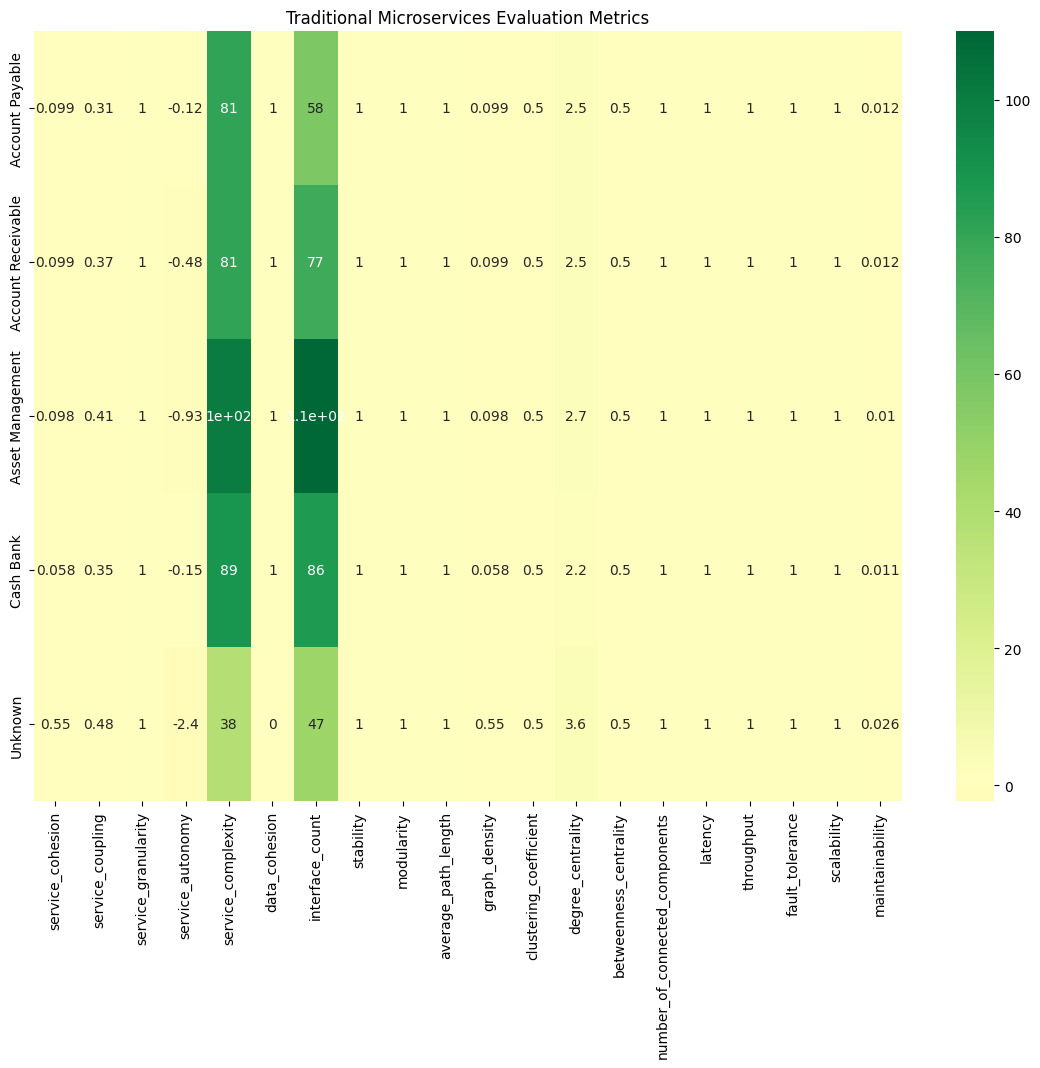

In [345]:
def run_traditional_evaluation():
    evaluator = TraditionalMicroservicesEvaluator()
    bpmn_dir = './assets'  # Directory containing BPMN XML files
    evaluator.parse_bpmn_files(bpmn_dir)
    metrics_df = evaluator.evaluate_metrics()
    
    # Visualize results
    plt.figure(figsize=(14, 10))
    sns.heatmap(metrics_df, annot=True, cmap='RdYlGn', center=0.5)
    plt.title('Traditional Microservices Evaluation Metrics')
    plt.show()
    
    return metrics_df

# Execute traditional evaluation
traditional_results = run_traditional_evaluation()

# 11. Compare Traditional and Graph-Based Approaches

In [346]:
def compare_approaches(traditional_df, graph_df):
    """Compare traditional and graph-based evaluation approaches"""
    # Normalize metrics to a common scale (0-1)
    def normalize(df):
        df_norm = df.copy()
        for col in df.columns:
            max_value = df[col].max()
            min_value = df[col].min()
            if max_value == min_value:
                df_norm[col] = float('nan')  # Set to NaN if all values are the same
            else:
                df_norm[col] = (df[col] - min_value) / (max_value - min_value)
        return df_norm
    
    norm_trad = normalize(traditional_df)
    norm_graph = normalize(graph_df)
    
    # Invert metrics where lower is better
    invert_metrics = ['service_coupling', 'service_complexity', 'interface_count', 
                      'average_path_length', 'degree_centrality', 'betweenness_centrality', 
                      'number_of_connected_components', 'latency']
    for metric in invert_metrics:
        if metric in norm_trad.columns:
            norm_trad[metric] = 1 - norm_trad[metric]
            norm_graph[metric] = 1 - norm_graph[metric]
    
    # Calculate average scores
    trad_scores = norm_trad.mean(axis=1, skipna=True)
    graph_scores = norm_graph.mean(axis=1, skipna=True)
    
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Traditional': trad_scores,
        'Graph-based': graph_scores
    })
    
    # Determine which method is better
    comparison['Better Method'] = comparison.apply(
        lambda row: 'Graph-based' if row['Graph-based'] > row['Traditional'] 
        else ('Traditional' if row['Traditional'] > row['Graph-based'] else 'Equal'), axis=1)
    
    return comparison, norm_trad, norm_graph

In [347]:
def visualize_comparison(norm_trad, norm_graph):
    """Create comprehensive visualization for comparison"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    categories = norm_trad.columns.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Mean values across all modules
    trad_values = norm_trad.mean().tolist()
    graph_values = norm_graph.mean().tolist()
    trad_values += trad_values[:1]
    graph_values += graph_values[:1]
    
    fig = plt.figure(figsize=(14, 10))
    
    # Radar Chart
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, trad_values, 'o-', linewidth=2, label='Traditional')
    ax.fill(angles, trad_values, alpha=0.25)
    
    ax.plot(angles, graph_values, 'o-', linewidth=2, label='Graph-based')
    ax.fill(angles, graph_values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_yticklabels([])
    ax.set_title('Comparison of Microservice Metrics', fontsize=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    
    plt.show()
    
    # Bar Chart of Average Scores
    comparison_df = pd.DataFrame({
        'Metric': categories,
        'Traditional': norm_trad.mean().values,
        'Graph-based': norm_graph.mean().values
    })
    
    comparison_df.plot(x='Metric', y=['Traditional', 'Graph-based'], kind='bar', figsize=(14, 8))
    plt.title('Average Metric Scores')
    plt.ylabel('Normalized Score')
    plt.xticks(rotation=45)
    plt.show()


Comparison of Traditional vs Graph-based Approaches:
                    Traditional  Graph-based Better Method
Account Payable        0.575604     0.509615   Traditional
Account Receivable     0.484630     0.509615   Graph-based
Asset Management       0.309929     0.509615   Graph-based
Cash Bank              0.488326     0.500000   Graph-based
ERP                         NaN     0.500000         Equal
Unknown                0.555556          NaN         Equal

Key Findings:
--------------------------------------------------------------------------------

Number of Modules where each method performs better:
Graph-based: 3
Equal: 2
Traditional: 1

Average Traditional Score: 0.483
Average Graph-based Score: 0.506
Overall Improvement: 4.76%


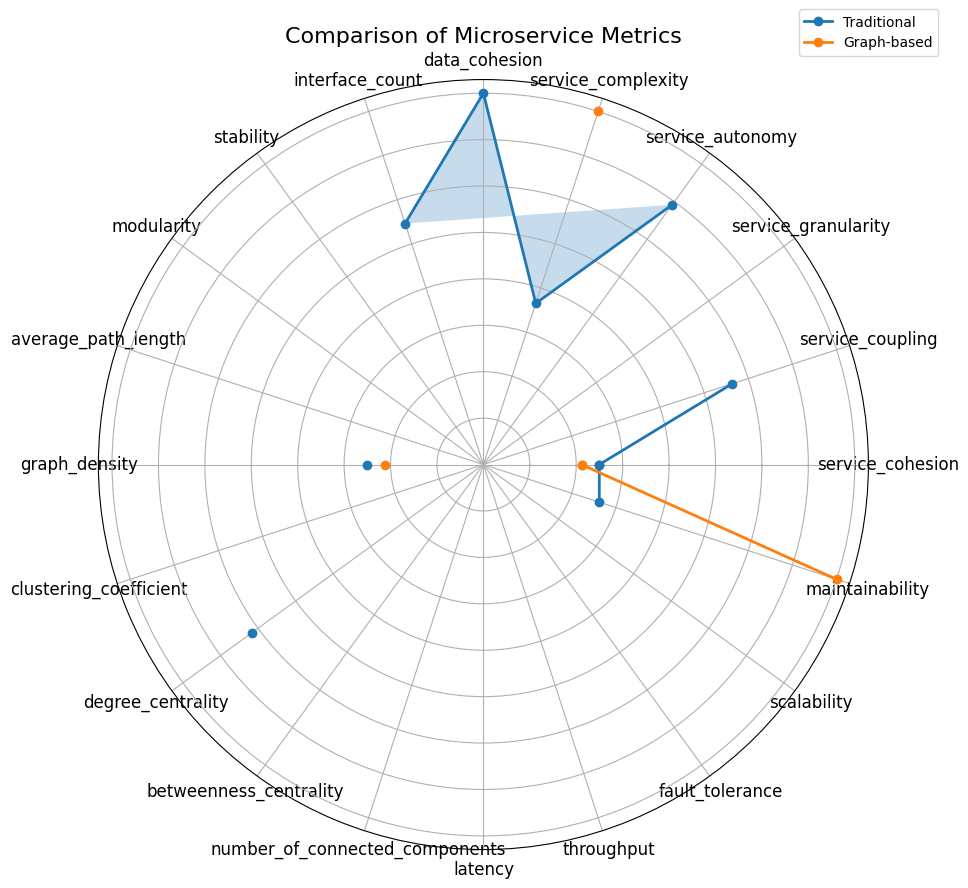

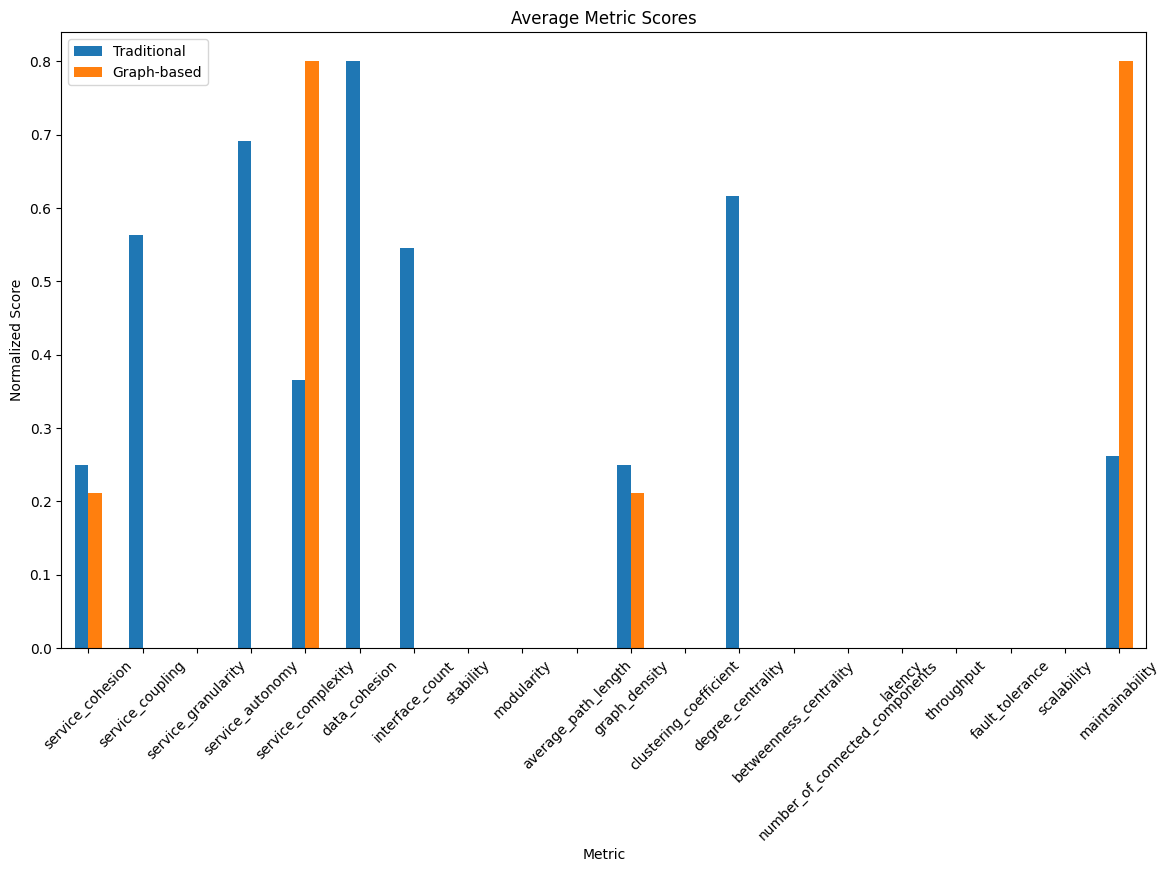

In [348]:
def run_comparative_analysis(traditional_df, graph_df):
    comparison, norm_trad, norm_graph = compare_approaches(traditional_df, graph_df)
    
    print("Comparison of Traditional vs Graph-based Approaches:")
    print("=" * 80)
    print(comparison)
    print("\nKey Findings:")
    print("-" * 80)
    
    # Count how many times each method is better
    better_counts = comparison['Better Method'].value_counts()
    print("\nNumber of Modules where each method performs better:")
    for method, count in better_counts.items():
        print(f"{method}: {count}")
    
    # Overall average scores
    avg_trad_score = comparison['Traditional'].mean()
    avg_graph_score = comparison['Graph-based'].mean()
    print(f"\nAverage Traditional Score: {avg_trad_score:.3f}")
    print(f"Average Graph-based Score: {avg_graph_score:.3f}")
    improvement = (avg_graph_score - avg_trad_score) / avg_trad_score * 100 if avg_trad_score > 0 else 0
    print(f"Overall Improvement: {improvement:.2f}%")
    
    # Visualize
    visualize_comparison(norm_trad, norm_graph)
    
    return comparison

# Run comparative analysis
comparison_results = run_comparative_analysis(traditional_results, evaluation_results)
